<a href="https://colab.research.google.com/github/zingarelli/alura-challenges-data-science-2022/blob/main/Semana-3/Alura_Challenges_%7C_Data_Science_2022_Semana_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Configurações e imports

In [73]:
# biblioteca para balanceio da target Churn
!pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)


In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# para o One-Hot Encoding das variáveis categóricas
from sklearn.preprocessing import OneHotEncoder

# para balanceamento do target
from imblearn.over_sampling import SMOTE

# para criação e validação dos modelos de machine learn
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# semente para garantir a replicabilidade do código
SEED = 12

pd.set_option('display.max_columns', 22)

In [75]:
# leitura da base tratada na Semana 1
df = pd.read_csv('https://raw.githubusercontent.com/zingarelli/alura-challenges-data-science-2022/main/Semana-1/analise_semana_1.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   cliente_ID                      7043 non-null   object 
 1   cancelou_plano                  7043 non-null   object 
 2   genero                          7043 non-null   object 
 3   maior_65_anos                   7043 non-null   int64  
 4   possui_companheiro_companheira  7043 non-null   object 
 5   possui_dependentes              7043 non-null   object 
 6   meses_contrato                  7043 non-null   int64  
 7   assina_telefone                 7043 non-null   object 
 8   multiplas_linhas_telefonicas    7043 non-null   object 
 9   tipo_assinatura_internet        7043 non-null   object 
 10  adicional_seguranca_online      7043 non-null   object 
 11  adicional_backup_online         7043 non-null   object 
 12  adicional_protecao_dispositivo  70

# Encoding das variáveis categóricas

## Label Encoding

Como feito na [Semana 2](https://github.com/zingarelli/alura-challenges-data-science-2022/blob/main/Semana-2/Alura_Challenges_%7C_Data_Science_2022_Semana_02.ipynb). 

In [76]:
# função que transforma os valores categóricos de uma coluna em valores numéricos
def label_encoding(categorical_col):
  # altera o tipo de "object" para o tipo "category"
  encode = categorical_col.astype('category')

  # atribui a cada categoria um valor numérico diferente
  return encode.cat.codes

In [77]:
# copiando a base de dados
df_encoded = df.copy()

# colunas categóricas (sem o "cliente_ID", pois não será utilizada)
cat_columns = ['cancelou_plano', 'genero', 'possui_companheiro_companheira', 
               'possui_dependentes', 'assina_telefone', 'multiplas_linhas_telefonicas',
               'tipo_assinatura_internet', 'adicional_seguranca_online',
               'adicional_backup_online', 'adicional_protecao_dispositivo',
               'adicional_suporte_VIP', 'assina_TV_cabo', 'assina_streaming_filmes',
               'plano_contratado', 'fatura_online', 'forma_pagamento']

# aplicando o label encoding
for col in cat_columns:
  df_encoded[col] = label_encoding(df_encoded[col])

df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   cliente_ID                      7043 non-null   object 
 1   cancelou_plano                  7043 non-null   int8   
 2   genero                          7043 non-null   int8   
 3   maior_65_anos                   7043 non-null   int64  
 4   possui_companheiro_companheira  7043 non-null   int8   
 5   possui_dependentes              7043 non-null   int8   
 6   meses_contrato                  7043 non-null   int64  
 7   assina_telefone                 7043 non-null   int8   
 8   multiplas_linhas_telefonicas    7043 non-null   int8   
 9   tipo_assinatura_internet        7043 non-null   int8   
 10  adicional_seguranca_online      7043 non-null   int8   
 11  adicional_backup_online         7043 non-null   int8   
 12  adicional_protecao_dispositivo  70

## One-Hot Encoding

Rever curso Kaggle: https://www.kaggle.com/code/alexisbcook/categorical-variables


**Atenção!**

Essa parte do código foi feita após a criação dos modelos e métricas, então sua aplicação não está bonita no código. Infelizmente, seria necessário refatorar muita coisa para ela ser aplicada. 

TO DO: Refatorar o projeto para poder escolher entre os dois encodings (label encoding ou OH encoding)

No caso do One-Hot Encoding, eu criei uma função, a ser chamada no momento de utilização dos modelos, quando as features que farão parte do modelo já foram escolhidas. O motivo disso é que o One-Hot Encoding cria colunas a mais e assim se perde o nome de cada coluna (cada coluna ganha um valor numérico sequencial). Não sei se existe algum parâmetro que poderia alterar isso e criar nomes mais representativos para as colunas.

In [78]:
def OH_encode(data, features):
  # criando o encoder
  OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

  # colunas categóricas + target
  cat_columns = features

  # criando um dataframe com o One-Hot Encoding aplicado
  OH_columns = pd.DataFrame(OH_encoder.fit_transform(data[cat_columns]))

  # copiando o dataframe sem as colunas que foram codificadas
  df_copy = data.drop(cat_columns, axis=1)

  # concatenando as colunas codificadas
  return pd.concat([df_copy, OH_columns], axis=1)

In [79]:
# teste da função
# features = ['genero', 'maior_65_anos', 'plano_contratado', 'fatura_online', 'forma_pagamento']
# df_OH_encoded = OH_encode(df, features)
# print(df_OH_encoded.shape)
# df_OH_encoded.head()

(7043, 30)


,cliente_ID,cancelou_plano,possui_companheiro_companheira,possui_dependentes,meses_contrato,assina_telefone,multiplas_linhas_telefonicas,tipo_assinatura_internet,adicional_seguranca_online,adicional_backup_online,adicional_protecao_dispositivo,...,2,3,4,5,6,7,8,9,10,11,12
0,0002-ORFBO,Nao,Sim,Sim,9,Sim,Nao,Cabo,Nao,Sim,Nao,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0003-MKNFE,Nao,Nao,Nao,9,Sim,Sim,Cabo,Nao,Nao,Nao,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0004-TLHLJ,Sim,Nao,Nao,4,Sim,Nao,Fibra,Nao,Nao,Sim,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0011-IGKFF,Sim,Sim,Nao,13,Sim,Nao,Fibra,Nao,Sim,Sim,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0013-EXCHZ,Sim,Sim,Nao,3,Sim,Nao,Fibra,Nao,Nao,Nao,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


# Verificar se a variável target `Churn` está desbalanceada

Ver artigo: https://www.alura.com.br/artigos/lidando-com-desbalanceamento-dados

Ver documentação: https://imbalanced-learn.org/stable/introduction.html

Ver treinamento da Sthe: https://cursos.alura.com.br/course/modelos-preditivos-dados-deteccao-fraude/task/106523

In [80]:
# armazenando os dados de cancelamento do plano em uma variável chamada churn
churn = df_encoded['cancelou_plano']

# separando entre clientes que estão ativos e aqueles que cancelaram o plano (former_customer)
# lembrando que o "Sim" significa que o cliente cancelou o plano
active_customers = (churn == 0).sum()
former_customers = (churn == 1).sum()
total_customers = len(churn)

print(f'Total de planos: {total_customers}')
print(f'Planos ativos: {active_customers}, {round(active_customers/total_customers*100, 2)}% do total')
print(f'Planos cancelados: {former_customers}, {round(former_customers/total_customers*100, 2)}% do total')

Total de planos: 7043
Planos ativos: 5174, 73.46% do total
Planos cancelados: 1869, 26.54% do total


Cerca de pouco mais de **um quarto da base** é formado por pessoas que **cancelaram** o plano (valor `1` na base), e o restante, de pessoas que mantiveram o plano (valor `0` na base). Isso faz com que a variável **target esteja desbalanceada**, o que pode **prejudicar** na criação dos modelos de Machine Learning. 

Desse modo, antes de criar os modelos é necessário fazer um balanceamento do target. 

Isso pode ser feito por meio do **oversampling**, isto é, criação de **novos dados (sintéticos) para aumentar** a quantidade de valores 1 na variável `cancelou_plano`, ou por meio do **undersampling**, isto é, selecionando na base **apenas alguns de registros** que possuam o valor 0 em `cancelou_plano`. Em ambas as estratégias, o objetivo e ter uma quantidade equivalente de registros com os valores 0 e 1.

## Estratégia de balanceamento 1: Oversampling
Utilizando o algoritmo SMOTE (KNN) para cópia de dados

In [81]:
# aplicando o random_state para garantir a replicabilidade do código
smote = SMOTE(random_state = SEED)

# separando as variáveis de treino e target
# client_ID também foi removida, pois não será utilizada na modelagem (é só um identificador)
x = df_encoded.drop(['cancelou_plano', 'cliente_ID'], axis=1)
y = df_encoded['cancelou_plano']  

# aplicando a SMOTE e salvando os novos dados criados
x_oversmp, y_oversmp = smote.fit_resample(x, y)

In [82]:
# criando a base balanceada com oversampling
df_oversmp = pd.concat([y_oversmp, x_oversmp], axis=1)
df_oversmp.sample(5)

,cancelou_plano,genero,maior_65_anos,possui_companheiro_companheira,possui_dependentes,meses_contrato,assina_telefone,multiplas_linhas_telefonicas,tipo_assinatura_internet,adicional_seguranca_online,adicional_backup_online,adicional_protecao_dispositivo,adicional_suporte_VIP,assina_TV_cabo,assina_streaming_filmes,plano_contratado,fatura_online,forma_pagamento,gasto_diario,gasto_mensal,gasto_total
2585,0,1,0,0,0,68,1,2,2,1,1,1,1,1,1,0,0,3,0.85,25.50,1821.80
6490,0,1,0,1,0,63,1,2,0,2,2,0,0,2,2,2,1,0,2.66,79.70,4786.15
5250,0,1,0,1,0,3,1,2,1,0,0,0,0,2,2,1,0,1,3.16,94.90,273.20
1942,1,0,0,0,0,13,0,1,0,2,0,0,2,2,0,1,1,0,1.52,45.55,597.00
1618,1,0,0,0,0,24,1,2,1,0,2,0,0,0,0,1,1,1,2.68,80.25,1861.50


In [83]:
# verificando o balanceamento e comparando com a base original
print('Tamanho base original: ', df.shape)
print('Tamanho base com oversample: ', df_oversmp.shape)
print('Valores de churn:')
print(df_oversmp['cancelou_plano'].value_counts())

Tamanho base original:  (7043, 22)
Tamanho base com oversample:  (10348, 21)
Valores de churn:
0    5174
1    5174
Name: cancelou_plano, dtype: int64


## TO DO: Estratégia de balanceamento 2: Undersampling

# Criação dos modelos de Machine Learning

Ver treinamento Sthe: https://cursos.alura.com.br/course/modelos-preditivos-dados-deteccao-fraude/task/106526

Rever curso Kaggle: 
> https://www.kaggle.com/code/dansbecker/your-first-machine-learning-model, 

> https://www.kaggle.com/code/dansbecker/random-forests

Ver código criado na Housing Prices Competition do Kaggle (precisa estar logado), leaderboard #12792: https://www.kaggle.com/code/zingarelli/ml-competitions-first-own-submission

Aula de ML da Imersão Dados 4 da Alura (talvez já não esteja disponível): https://www.youtube.com/watch?v=8VsqXXXHp8U

Criei algumas funções para etapas que serão utilizadas pelos dois modelos, para evitar repetição de código.

In [84]:
# função que separa e retorna os dados de treino e teste, baseado nas features escolhidas
def get_training_data(data, features):
  # separando target e features
  y = data['cancelou_plano']
  X = data[features]  

  # retorna os dados de treino e validação (por padrão 25% dos dados para validação)
  return train_test_split(X, y, random_state=SEED)

In [85]:
# função que imprime as métricas de acurácia, precisão, recall (sensibilidade), F1
# e também faz o plot da matriz de confusão
def get_metrics(test, prediction):
  # métricas de validação do modelo criado
  print('-'*40 + '\nResultados do Modelo\n' + '-'*40)
  print('Acurácia (acerto geral): ', metrics.accuracy_score(test, prediction))
  print('Precisão (acerto de quem cancelou o plano, dentre os positivos reais): ', metrics.precision_score(test, prediction))
  print('Recall (acerto de quem cancelou o plano, dentre todos os positivos): ', metrics.recall_score(test, prediction)) 
  print('F1 (média harmônica precisão e recall): ', metrics.f1_score(test, prediction))

  # plot da matriz de confusão
  cm = metrics.confusion_matrix(test, prediction)
  disp = metrics.ConfusionMatrixDisplay(cm)
  disp.plot()

## Modelo 1: Random Forest

Ver documentação: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [86]:
# função para criar o modelo e aplicar algumas métricas
# data: base de dados
# features: colunas a serem consideradas para o treino
# n_trees: número de árvores da floresta
# depth: faz a "poda" das árvores após atingir a profundidade (para evitar overfitting)
def random_forest_model(data, features, n_trees=100, depth=5):  
  # separando os dados de treino e validação (por padrão 25% dos dados para validação)
  X_train, X_test, y_train, y_test = get_training_data(data, features)

  # criando o modelo e predizendo os resultados de teste
  rf = RandomForestClassifier(random_state=SEED, n_estimators=n_trees, max_depth=depth)
  rf.fit(X_train, y_train)
  y_pred = rf.predict(X_test)

  # print das métricas e matriz de confusão
  get_metrics(y_test, y_pred)

----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.7935833011209895
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.7758379888268156
Recall (acerto de quem cancelou o plano, dentre todos os positivos):  0.8391238670694864
F1 (média harmônica precisão e recall):  0.8062409288824384
----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.8001546192500967
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.7804030576789437
Recall (acerto de quem cancelou o plano, dentre todos os positivos):  0.8481873111782477
F1 (média harmônica precisão e recall):  0.8128845457835686
----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.7932992617830777
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.66

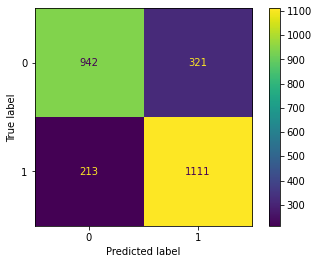

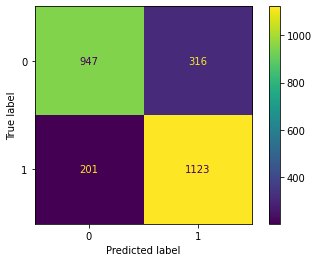

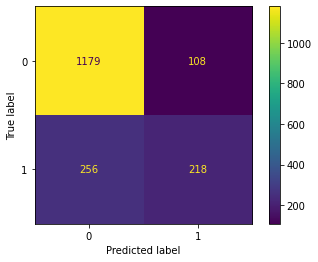

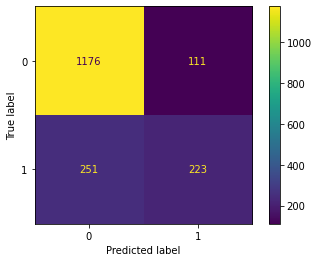

In [87]:
# escolhendo algumas colunas para o modelo
features = ['genero', 'maior_65_anos', 'gasto_mensal', 'meses_contrato', 'plano_contratado']
features_2 = ['genero', 'maior_65_anos', 'gasto_mensal', 'meses_contrato', 'plano_contratado', 'possui_companheiro_companheira', 'possui_dependentes']

# testando o modelo com diferentes parâmetros e features
# usando a base de dados balanceada com oversampling
random_forest_model(df_oversmp, features, 150, 10)
random_forest_model(df_oversmp, features_2, 150, 10)

# mesmo teste, com a base de dados original
random_forest_model(df_encoded, features, 150, 10)
random_forest_model(df_encoded, features_2, 150, 10)


## Modelo 2: SVC (Support Vector Classification)

Ver documentação: 

> https://scikit-learn.org/stable/modules/svm.html#

> https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

TO DO: verificar como alterar os parâmetros para otimizar o modelo

In [88]:
# função para criar o modelo e aplicar algumas métricas
def SVC_model(data, features):
  X_train, X_test, y_train, y_test = get_training_data(data, features)

  # criando o modelo e predizendo os resultados de teste
  clf = SVC(random_state=SEED)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  # print das métricas e matriz de confusão
  get_metrics(y_test, y_pred)

----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.7394665635871666
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.7275910364145658
Recall (acerto de quem cancelou o plano, dentre todos os positivos):  0.7847432024169184
F1 (média harmônica precisão e recall):  0.7550872093023256
----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.7421724004638578
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.7292393579902303
Recall (acerto de quem cancelou o plano, dentre todos os positivos):  0.7892749244712991
F1 (média harmônica precisão e recall):  0.758070366340225
----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.7910278250993753
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.705

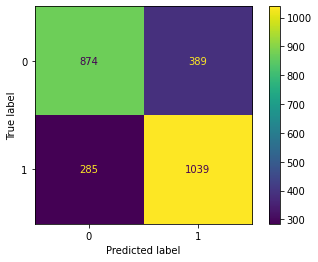

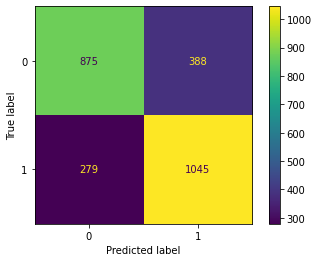

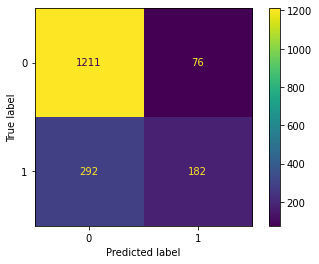

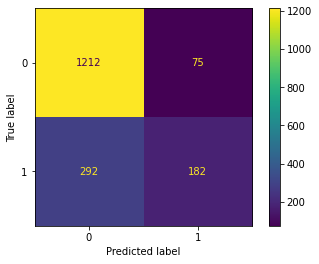

In [89]:
# escolhendo algumas colunas para o modelo
features = ['genero', 'maior_65_anos', 'gasto_mensal', 'meses_contrato', 'plano_contratado']
features_2 = ['genero', 'maior_65_anos', 'gasto_mensal', 'meses_contrato', 'plano_contratado', 'possui_companheiro_companheira', 'possui_dependentes']

# testando o modelo com diferentes parâmetros e features
# usando a base de dados balanceada com oversampling
SVC_model(df_oversmp, features)
SVC_model(df_oversmp, features_2)

# mesmo teste, com a base de dados original
SVC_model(df_encoded, features)
SVC_model(df_encoded, features_2)


# TO DO: análise de métricas e testar modelos com o outro tipo de encoding

Ver aula da Sthe: https://cursos.alura.com.br/course/modelos-preditivos-dados-deteccao-fraude/task/106629

## Teste com o One-Hot Encoding

Sim, essa parte está bem hardcoded e muito feia... :(

Quis testar o One-Hot Encoding quando grande parte do projeto já havia sido feita. Aplicá-lo de maneira mais padronizada envolveria refatoração de muito código, o que não vou conseguir fazer para entregar o desafio dentro do prazo.

----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.7309625048318515
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.6817129629629629
Recall (acerto de quem cancelou o plano, dentre todos os positivos):  0.8897280966767371
F1 (média harmônica precisão e recall):  0.7719528178243774
----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.7301894085813684
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.6813441483198146
Recall (acerto de quem cancelou o plano, dentre todos os positivos):  0.8882175226586103
F1 (média harmônica precisão e recall):  0.7711475409836065


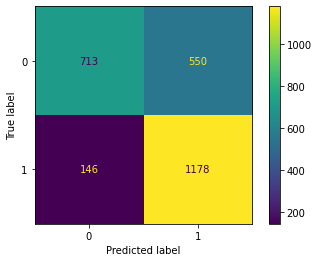

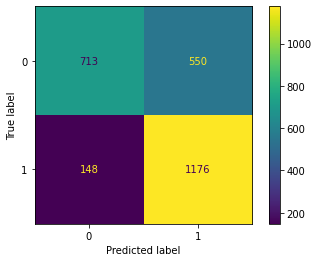

In [90]:
# encode das colunas categóricas que irão para o modelo
cat_features = ['genero', 'maior_65_anos', 'plano_contratado']
df_OH_encoded = OH_encode(df, cat_features)

# alterando o target para 0 (não cancelou) ou 1 (cancelou)
df_OH_encoded['cancelou_plano'] = df_OH_encoded['cancelou_plano'].apply(lambda x : 1 if x == 'Sim' else 0)

# o One-Hot Encoding modificou as colunas, então preciso alterar as features
features = [0, 1, 2, 3, 4, 5, 6]

# fazendo o oversampling
smote = SMOTE(random_state = SEED)
x = df_OH_encoded[features]
y = df_OH_encoded['cancelou_plano']
x_oversmp, y_oversmp = smote.fit_resample(x, y)
df_OH_oversmp = pd.concat([y_oversmp, x_oversmp], axis=1)

# testando os modelos
random_forest_model(df_OH_oversmp, features, 150, 10)
SVC_model(df_OH_oversmp, features)



Os resultados dos dados com One-Hot Encoding não ficaram bons (com exceção do Recall, que ficou mais alto). No entanto, pode ser que eu tenha errado em algum passo, pois copiei e colei muito código. 

Como essa parte foi feita com pressa, vou optar por manter os dados com o Label Encoding para fazer as análises finais.